# Mô hình hồi quy Logistic và Perceptron trong dự báo nguy cơ khởi phát Đái tháo đường  


Notebook này triển khai **hồi quy Logistic** và **Perceptron tuyến tính** nhằm dự báo nguy cơ **khởi phát ĐTĐ** trên dữ liệu *Pima Indians Diabetes*, đồng thời diễn giải kết quả dưới lăng kính **y học lâm sàng**.

## Khung phương pháp
- **Hồi quy Logistic:** mô hình nhị phân cho phép ước lượng xác suất mắc ĐTĐ; hệ số có khả năng **diễn giải** (liên hệ đến nguy cơ tương đối khi các biến đã chuẩn hóa).
- **Perceptron:** phân tách tuyến tính; hiệu năng tham chiếu cho bài toán hai lớp.

## Chỉ số đánh giá (ý nghĩa lâm sàng)
- **Độ nhạy (Sensitivity/Recall):** xác suất phát hiện đúng người **thực sự mắc bệnh** — quan trọng trong **sàng lọc** để hạn chế bỏ sót.
- **Độ đặc hiệu (Specificity):** xác suất nhận diện đúng người **không bệnh** — hạn chế chẩn đoán nhầm.
- **ROC AUC, PR AUC, F1-score:** tổng quát hóa hiệu năng mô hình dưới nhiều ngưỡng quyết định.


## Khởi tạo thí nghiệm

### Khai báo thư viện

In [13]:
# [Chuẩn bị] — nạp dữ liệu đã tiền xử lý
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score

PROCESSED_DIR = "data/processed"
X_train_scaled = pd.read_csv(f"{PROCESSED_DIR}/X_train_scaled.csv")
X_test_scaled  = pd.read_csv(f"{PROCESSED_DIR}/X_test_scaled.csv")
y_train = pd.read_csv(f"{PROCESSED_DIR}/y_train.csv", header=None).iloc[:,0]
y_test  = pd.read_csv(f"{PROCESSED_DIR}/y_test.csv",  header=None).iloc[:,0]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [14]:
# Sanity checks to avoid shape mismatch
print("Shapes:", X_train_scaled.shape if 'X_train_scaled' in globals() else X_train.shape,
                  X_test_scaled.shape if 'X_test_scaled' in globals() else X_test.shape,
                  y_train.shape, y_test.shape)
assert len(X_train_scaled) == len(y_train) if 'X_train_scaled' in globals() else len(X_train) == len(y_train), "Mismatch train sizes"
assert len(X_test_scaled)  == len(y_test)  if 'X_test_scaled' in globals()  else len(X_test)  == len(y_test),  "Mismatch test sizes"


Shapes: (537, 8) (231, 8) (537,) (231,)


### Tham số thực nghiệm

In [15]:

log_reg = LogisticRegression(max_iter=5000, solver="liblinear", random_state=42)
log_reg.fit(X_train_scaled, y_train)

log_prob = log_reg.predict_proba(X_test_scaled)[:, 1]
eval_logit = evaluate_binary(y_test, log_prob, threshold=0.5)
eval_logit


{'accuracy': 0.7445887445887446,
 'precision': 0.671875,
 'recall_sensitivity': 0.5308641975308642,
 'specificity': np.float64(0.86),
 'f1': 0.593103448275862,
 'roc_auc': np.float64(0.8361316872427983),
 'avg_precision': np.float64(0.7189412191991704),
 'tn': 129,
 'fp': 21,
 'fn': 38,
 'tp': 43,
 'threshold': 0.5}

## 1. Dữ liệu kiểm nghiệm (Validation Dataset)

Chúng ta chuẩn bị dữ liệu kiểm nghiệm theo phương pháp hold-out:
+ Tập dữ liệu được chia thành 2 phần train/test với tỉ lệ 7/3 (đã làm trước)
+ Tập train sẽ được dùng để huấn luyện, điều chỉnh tham số với chiến lược:
    + Hold-out (tiếp tục chia 7/3 với train/valid)
    + k-fold (chia thành k phần đều nhau với k-1 phần cho train/1 phần cho valid)
    + Trong đó, train là dùng huấn luyện và valid dùng điều chỉnh tham số
+ Tập test dùng để kiểm nghiệm lại độ hiệu quả của thuật toán sau khi chọn mô hình tối ưu

In [19]:
# [Đánh giá trên test] — hàm tiện ích và báo cáo
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, average_precision_score, precision_recall_curve,
                             confusion_matrix)

def evaluate_binary(y_true, y_prob, threshold=0.5):
    from sklearn.metrics import roc_auc_score
    import numpy as np
    
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall_sensitivity": recall_score(y_true, y_pred, zero_division=0),
        "specificity": tn/(tn+fp) if (tn+fp)>0 else 0.0,
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_prob),
        "avg_precision": average_precision_score(y_true, y_prob),
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
        "threshold": threshold
    }

In [22]:
# [Logistic tốt nhất] — đánh giá & vẽ ROC/PR
# [Tuning] — Logistic Regression
param_log = {"C":[0.01,0.1,1.0,10.0], "penalty":["l1","l2"], "solver":["liblinear"]}
gs_log = GridSearchCV(LogisticRegression(max_iter=2000), param_grid=param_log,
                      scoring="roc_auc", cv=cv, n_jobs=-1)
gs_log.fit(X_train_scaled, y_train)
print("Best Logistic:", gs_log.best_params_, "CV AUC=", gs_log.best_score_)
best_log = gs_log.best_estimator_
best_log_prob = best_log.predict_proba(X_test_scaled)[:, 1]
eval_log = evaluate_binary(y_test, best_log_prob, threshold=0.5)
print(eval_log)

Best Logistic: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'} CV AUC= 0.8373765494818126
{'accuracy': 0.7445887445887446, 'precision': 0.671875, 'recall_sensitivity': 0.5308641975308642, 'specificity': np.float64(0.86), 'f1': 0.593103448275862, 'roc_auc': np.float64(0.8361316872427983), 'avg_precision': np.float64(0.7189412191991704), 'tn': 129, 'fp': 21, 'fn': 38, 'tp': 43, 'threshold': 0.5}


In [29]:
# [Perceptron tốt nhất] — đánh giá & vẽ ROC/PR
# [Tuning] — Perceptron (GridSearchCV, scorer dùng decision_function)


def perc_auc(est, X, y):
    # Perceptron không có predict_proba, ta dùng decision_function
    d = est.decision_function(X)
    return roc_auc_score(y, d)

param_perc = {
    "penalty": [None, "l2", "l1", "elasticnet"],
    "alpha": [0.0001, 0.001, 0.01],
    "max_iter": [2000]
}

gs_perc = GridSearchCV(
    Perceptron(random_state=42),
    param_grid=param_perc,
    scoring=make_scorer(perc_auc, needs_proba=False),
    cv=cv,
    n_jobs=-1,
    error_score=0
)

gs_perc.fit(X_train_scaled, y_train)
print("Best Perceptron:", gs_perc.best_params_, "CV AUC=", gs_perc.best_score_)

# Chạy sau khi gs_perc.fit() đã hoàn thành
cv_results_df = pd.DataFrame(gs_perc.cv_results_)

# Hiển thị các cột quan trọng để xem tham số và điểm số
print("\nChi tiết kết quả Cross-Validation của Perceptron:")
print(cv_results_df[['param_penalty', 'param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']])

best_perc = gs_perc.best_estimator_
dec = best_perc.decision_function(X_test_scaled)
# chuẩn hoá sang [0,1] để xem PR/F1 theo ngưỡng
prob_perc = (dec - dec.min())/(dec.max()-dec.min()) if (dec.max()>dec.min()) else (dec>0).astype(float)
eval_perc = evaluate_binary(y_test, prob_perc, threshold=0.5)
eval_perc

Best Perceptron: {'alpha': 0.0001, 'max_iter': 2000, 'penalty': None} CV AUC= 0.0

Chi tiết kết quả Cross-Validation của Perceptron:
   param_penalty  param_alpha  mean_test_score  std_test_score  \
0           None       0.0001              0.0             0.0   
1             l2       0.0001              0.0             0.0   
2             l1       0.0001              0.0             0.0   
3     elasticnet       0.0001              0.0             0.0   
4           None       0.0010              0.0             0.0   
5             l2       0.0010              0.0             0.0   
6             l1       0.0010              0.0             0.0   
7     elasticnet       0.0010              0.0             0.0   
8           None       0.0100              0.0             0.0   
9             l2       0.0100              0.0             0.0   
10            l1       0.0100              0.0             0.0   
11    elasticnet       0.0100              0.0             0.0   

    rank

{'accuracy': 0.7012987012987013,
 'precision': 0.8333333333333334,
 'recall_sensitivity': 0.18518518518518517,
 'specificity': np.float64(0.98),
 'f1': 0.30303030303030304,
 'roc_auc': np.float64(0.8099588477366254),
 'avg_precision': np.float64(0.6972990170728242),
 'tn': 147,
 'fp': 3,
 'fn': 66,
 'tp': 15,
 'threshold': 0.5}

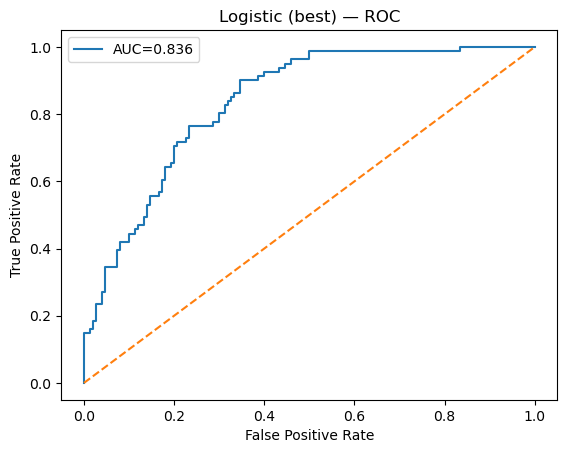

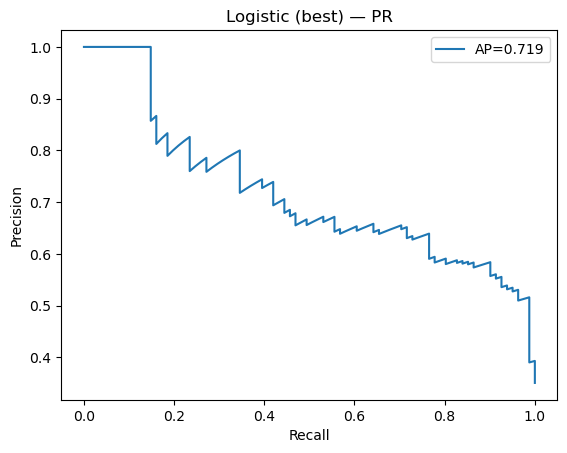

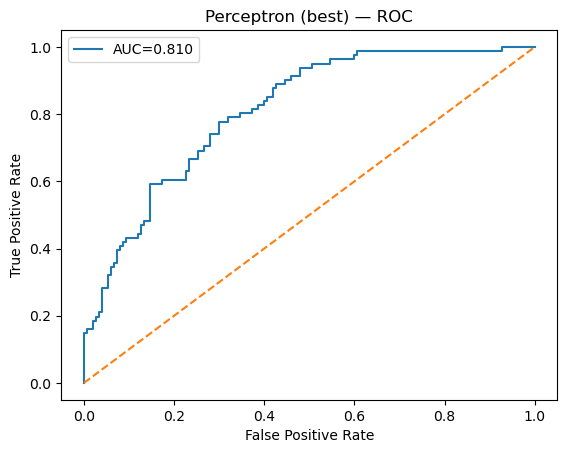

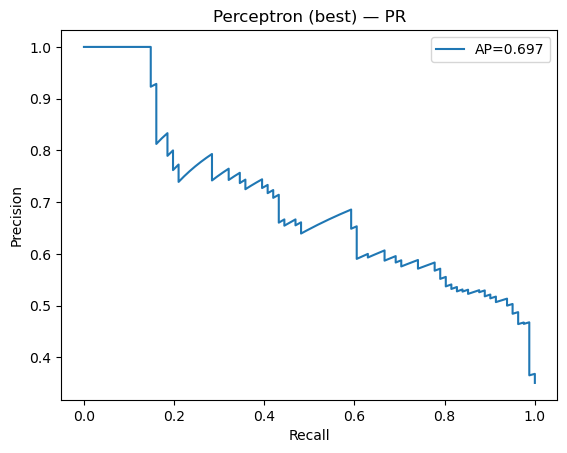

In [30]:
# [Đồ thị] — ROC & PR (matplotlib thuần, một hình/biểu đồ)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

def plot_roc_pr(y_true, y_prob, title_prefix):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_true, y_prob):.3f}")
    plt.plot([0,1],[0,1],'--'); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} — ROC"); plt.legend(); plt.show()

    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(); plt.plot(rec, prec, label=f"AP={average_precision_score(y_true, y_prob):.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title_prefix} — PR"); plt.legend(); plt.show()

plot_roc_pr(y_test, best_log_prob, "Logistic (best)")
plot_roc_pr(y_test, prob_perc, "Perceptron (best)")

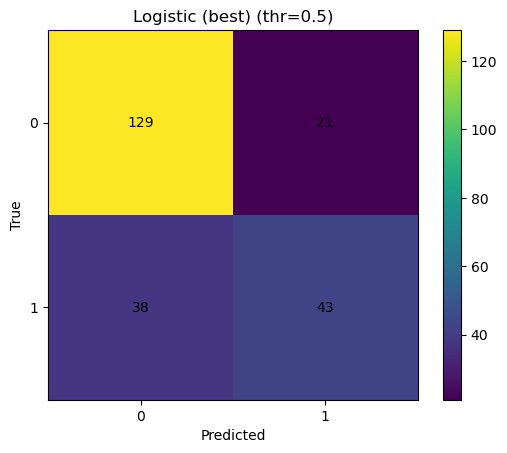

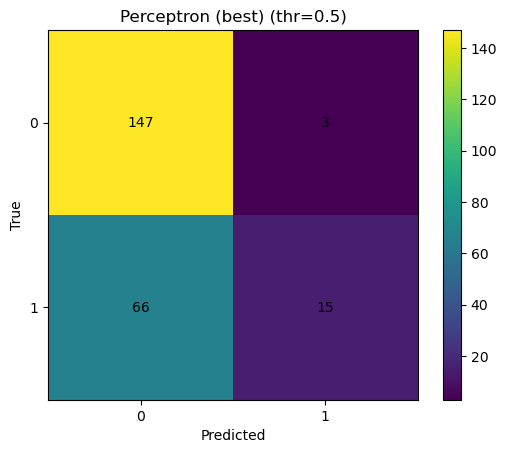

In [31]:
# [Ma trận nhầm lẫn]
def show_conf_matrix(y_true, y_prob, thr, title):
    import numpy as np, matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    fig, ax = plt.subplots(); im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(f"{title} (thr={thr})"); ax.set_xticks([0,1]); ax.set_xticklabels(['0','1'])
    ax.set_yticks([0,1]); ax.set_yticklabels(['0','1'])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    ax.set_ylabel('True'); ax.set_xlabel('Predicted'); fig.colorbar(im, ax=ax); plt.show()

show_conf_matrix(y_test, best_log_prob, 0.5, "Logistic (best)")
show_conf_matrix(y_test, prob_perc, 0.5, "Perceptron (best)")

In [32]:
# Perceptron — baseline fit (probability proxy via min-max of decision_function)
perc = Perceptron(max_iter=2000, random_state=42)
perc.fit(X_train_scaled, y_train)
dec = perc.decision_function(X_test_scaled)
if np.ptp(dec) == 0:
    prob_perc = (dec > 0).astype(float)
else:
    prob_perc = (dec - dec.min()) / (dec.max() - dec.min())
eval_perc = evaluate_binary(y_test, prob_perc, threshold=0.5)
eval_perc

{'accuracy': 0.7012987012987013,
 'precision': 0.8333333333333334,
 'recall_sensitivity': 0.18518518518518517,
 'specificity': np.float64(0.98),
 'f1': 0.30303030303030304,
 'roc_auc': np.float64(0.8099588477366254),
 'avg_precision': np.float64(0.6972990170728242),
 'tn': 147,
 'fp': 3,
 'fn': 66,
 'tp': 15,
 'threshold': 0.5}

In [33]:
# Cross-validation & hyperparameter tuning (5-fold) — Logistic
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_log = {
    "C": [0.01, 0.1, 1.0, 10.0],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"]
}
gs_log = GridSearchCV(
    LogisticRegression(max_iter=2000),
    param_grid=param_log,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)
gs_log.fit(X_train_scaled, y_train)
gs_log.best_params_, gs_log.best_score_

({'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'},
 np.float64(0.8373765494818126))

In [34]:
# Refit best logistic and evaluate
best_log = gs_log.best_estimator_
best_log_prob = best_log.predict_proba(X_test_scaled)[:,1]
eval_logit_best = evaluate_binary(y_test, best_log_prob, threshold=0.5)
eval_logit_best

{'accuracy': 0.7445887445887446,
 'precision': 0.671875,
 'recall_sensitivity': 0.5308641975308642,
 'specificity': np.float64(0.86),
 'f1': 0.593103448275862,
 'roc_auc': np.float64(0.8361316872427983),
 'avg_precision': np.float64(0.7189412191991704),
 'tn': 129,
 'fp': 21,
 'fn': 38,
 'tp': 43,
 'threshold': 0.5}

In [36]:
# Cross-validation & hyperparameter tuning (5-fold) — Perceptron
param_perc = {
    "penalty": [None, "l2", "l1", "elasticnet"],
    "alpha": [0.0001, 0.001, 0.01],
    "max_iter": [2000]
}
gs_perc = GridSearchCV(
    Perceptron(random_state=42),
    param_grid=param_perc,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    error_score=0
)
# Use decision_function to compute ROC AUC inside GridSearchCV via a wrapper
# We'll implement a custom scorer if needed, but scikit-learn's roc_auc can accept decision_function directly.
from sklearn.metrics import make_scorer, roc_auc_score
def perc_auc(est, X, y):
    d = est.decision_function(X)
    # Map decision to rankable scores (no probability needed)
    return roc_auc_score(y, d)
gs_perc.scoring = make_scorer(perc_auc, needs_proba=False, greater_is_better=True)
gs_perc.fit(X_train_scaled, y_train)
gs_perc.best_params_, gs_perc.best_score_

({'alpha': 0.0001, 'max_iter': 2000, 'penalty': None}, np.float64(0.0))

## Lượng giá thuật toán (Evaluate Algorithms)

### Baselines

In [37]:
# Refit best perceptron and evaluate
best_perc = gs_perc.best_estimator_
dec_best = best_perc.decision_function(X_test_scaled)
if np.ptp(dec_best) == 0:
    prob_perc_best = (dec_best > 0).astype(float)
else:
    prob_perc_best = (dec_best - dec_best.min()) / (dec_best.max() - dec_best.min())
eval_perc_best = evaluate_binary(y_test, prob_perc_best, threshold=0.5)
eval_perc_best

{'accuracy': 0.7012987012987013,
 'precision': 0.8333333333333334,
 'recall_sensitivity': 0.18518518518518517,
 'specificity': np.float64(0.98),
 'f1': 0.30303030303030304,
 'roc_auc': np.float64(0.8099588477366254),
 'avg_precision': np.float64(0.6972990170728242),
 'tn': 147,
 'fp': 3,
 'fn': 66,
 'tp': 15,
 'threshold': 0.5}

In [41]:
# Logistic coefficients (best)
X_cols = X_train_scaled.columns
coef = pd.Series(best_log.coef_[0], index=X_cols).sort_values()
coef

SkinThickness              -0.092576
BloodPressure              -0.041476
Insulin                    -0.034808
Age                         0.100412
DiabetesPedigreeFunction    0.215265
Pregnancies                 0.460104
BMI                         0.732843
Glucose                     1.125767
dtype: float64

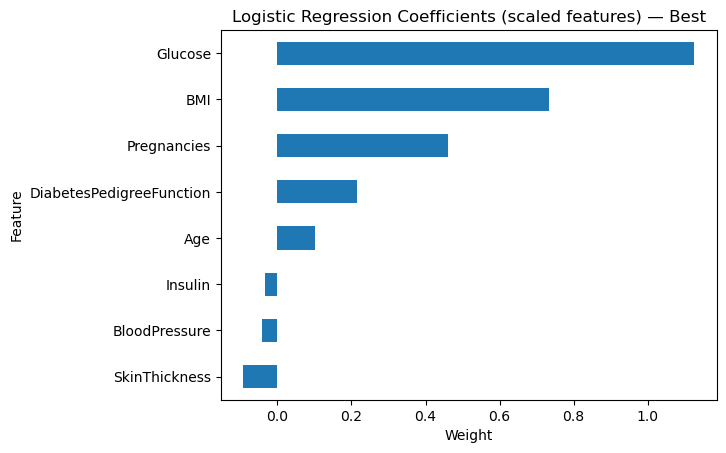

In [42]:
# Plot coefficients
plt.figure()
coef.plot(kind='barh')
plt.title("Logistic Regression Coefficients (scaled features) — Best")
plt.xlabel("Weight")
plt.ylabel("Feature")
plt.show()

### Tinh chỉnh mô hình (Tuning Models)

In [44]:
# [Chuẩn bị] — nạp dữ liệu đã tiền xử lý
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score

PROCESSED_DIR = "data/processed"
X_train_scaled = pd.read_csv(f"{PROCESSED_DIR}/X_train_scaled.csv")
X_test_scaled  = pd.read_csv(f"{PROCESSED_DIR}/X_test_scaled.csv")
y_train = pd.read_csv(f"{PROCESSED_DIR}/y_train.csv", header=None).iloc[:,0]
y_test  = pd.read_csv(f"{PROCESSED_DIR}/y_test.csv",  header=None).iloc[:,0]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [45]:
# [Tuning] — Logistic Regression (GridSearchCV theo ROC AUC)
param_log = {"C":[0.01,0.1,1.0,10.0], "penalty":["l1","l2"], "solver":["liblinear"]}
gs_log = GridSearchCV(LogisticRegression(max_iter=2000), param_grid=param_log,
                      scoring="roc_auc", cv=cv, n_jobs=-1)
gs_log.fit(X_train_scaled, y_train)
print("Best Logistic:", gs_log.best_params_, "CV AUC=", gs_log.best_score_)

Best Logistic: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'} CV AUC= 0.8373765494818126


In [47]:
# [Tuning] — Perceptron (GridSearchCV, scorer dùng decision_function)
from sklearn.metrics import make_scorer
def perc_auc(est, X, y): return roc_auc_score(y, est.decision_function(X))
param_perc = {"penalty":[None,"l2","l1","elasticnet"], "alpha":[1e-4,1e-3,1e-2], "max_iter":[2000]}
gs_perc = GridSearchCV(Perceptron(random_state=42), param_grid=param_perc,
                       scoring=make_scorer(perc_auc, needs_proba=False, greater_is_better=True),
                       cv=cv, n_jobs=-1,error_score=0 )
gs_perc.fit(X_train_scaled, y_train)
print("Best Perceptron:", gs_perc.best_params_, "CV AUC=", gs_perc.best_score_)

Best Perceptron: {'alpha': 0.0001, 'max_iter': 2000, 'penalty': None} CV AUC= 0.0


## Kiểm nghiệm kết quả trên Test (Finalize Model)

### Load và tiền xử lý tập test

In [51]:
# [Tuning] — GridSearchCV cho MLP (ROC AUC, 5-fold)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_mlp = {
    "hidden_layer_sizes": [(32,), (64,), (128,), (64,32)],
    "activation": ["relu", "tanh"],
    "alpha": [1e-5, 1e-4, 1e-3],
    "learning_rate_init": [0.001, 0.01]
}

gs_mlp = GridSearchCV(
    MLPClassifier(max_iter=2000, random_state=42, solver='adam'),
    param_grid=param_mlp, 
    scoring="roc_auc", 
    cv=cv, 
    n_jobs=-1
)

gs_mlp.fit(X_train_scaled, y_train)

# Sau khi chạy xong, tạo biến best_mlp
best_mlp = gs_mlp.best_estimator_

print("Best MLP:", gs_mlp.best_params_, "CV AUC=", gs_mlp.best_score_)

Best MLP: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.001} CV AUC= 0.8365860597439545


D:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


## Đánh giá Baseline

In [52]:
# --- Đánh giá Hồi quy Logistic ---
prob_log_final = best_log.predict_proba(X_test_scaled)[:,1]
eval_log_final = evaluate_binary(y_test, prob_log_final, threshold=0.5)
print("--- Kết quả Hồi quy Logistic trên tập Test ---")
print(pd.Series(eval_log_final))

# --- Đánh giá Perceptron ---
dec_perc_final = best_perc.decision_function(X_test_scaled)
prob_perc_final = (dec_perc_final - dec_perc_final.min()) / (dec_perc_final.max() - dec_perc_final.min()) if (dec_perc_final.max() > dec_perc_final.min()) else (dec_perc_final > 0).astype(float)
eval_perc_final = evaluate_binary(y_test, prob_perc_final, threshold=0.5)
print("\n--- Kết quả Perceptron trên tập Test ---")
print(pd.Series(eval_perc_final))

# --- Đánh giá Mạng Nơ-ron MLP ---
prob_mlp_final = best_mlp.predict_proba(X_test_scaled)[:,1]
eval_mlp_final_05 = evaluate_binary(y_test, prob_mlp_final, threshold=0.5)
eval_mlp_final_0448 = evaluate_binary(y_test, prob_mlp_final, threshold=0.448) # Đánh giá ở ngưỡng ADAP
print("\n--- Kết quả MLP trên tập Test (ngưỡng 0.5) ---")
print(pd.Series(eval_mlp_final_05))
print("\n--- Kết quả MLP trên tập Test (ngưỡng 0.448) ---")
print(pd.Series(eval_mlp_final_0448))

--- Kết quả Hồi quy Logistic trên tập Test ---
accuracy                0.744589
precision               0.671875
recall_sensitivity      0.530864
specificity             0.860000
f1                      0.593103
roc_auc                 0.836132
avg_precision           0.718941
tn                    129.000000
fp                     21.000000
fn                     38.000000
tp                     43.000000
threshold               0.500000
dtype: float64

--- Kết quả Perceptron trên tập Test ---
accuracy                0.701299
precision               0.833333
recall_sensitivity      0.185185
specificity             0.980000
f1                      0.303030
roc_auc                 0.809959
avg_precision           0.697299
tn                    147.000000
fp                      3.000000
fn                     66.000000
tp                     15.000000
threshold               0.500000
dtype: float64

--- Kết quả MLP trên tập Test (ngưỡng 0.5) ---
accuracy                0.740260
precisio

## Lưu kết quả thí nghiệm

In [54]:
import joblib
import json
import os

# --- 8. Lưu kết quả thí nghiệm cho Logistic & Perceptron ---

os.makedirs("models", exist_ok=True)

# Lưu mô hình Logistic tốt nhất
joblib.dump(best_log, "models/best_logistic_model.joblib")
# Lưu mô hình Perceptron tốt nhất
joblib.dump(best_perc, "models/best_perceptron_model.joblib")

print("Đã lưu các mô hình vào thư mục 'models'.")

# Tổng hợp kết quả đánh giá cuối cùng của file 02
final_evaluation_linear = {
    "logistic_regression_final": eval_log_final,
    "perceptron_final": eval_perc_final
}

# Lưu kết quả vào file JSON
with open("models/final_evaluation_linear_models.json", "w") as f:
    json.dump(final_evaluation_linear, f, indent=4)

print("Đã lưu kết quả đánh giá của các mô hình tuyến tính vào file JSON.")

Đã lưu các mô hình vào thư mục 'models'.
Đã lưu kết quả đánh giá của các mô hình tuyến tính vào file JSON.


# Kết thúc

## Tài liệu tham khảo (trích yếu)
1. WHO Consultation. *Definition, Diagnosis and Classification of Diabetes Mellitus and its Complications.* WHO, 1999.
2. National Diabetes Data Group. *Classification and Diagnosis of Diabetes Mellitus and Other Categories of Glucose Intolerance.* 1979.
3. Ứng dụng mạng nơ-ron (ADAP) cho dự báo ĐTĐ ở quần thể Pima (bản kinh điển).